In [2]:
import os
import sys
import gzip
import code
import urllib
import importlib
import tensorflow.python.platform
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tqdm import tqdm
from PIL import Image

In [3]:
COLAB = False
BRANCH = 'main'

In [4]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/Shareddrives/ML_Road_Segmentation/CS-433-project-2/project_road_segmentation'
    os.chdir(drive_path)
    from helpers.colab import mount_and_pull
    BRANCH_NAME = BRANCH
    mount_and_pull(BRANCH_NAME, drive, os)

In [56]:
%load_ext autoreload
%autoreload 2

from helpers.image_processing import *
from helpers.file_manipulation import *
from helpers.constants import *
from helpers.prediction_checking import *
from helpers.machine_learning import *
from helpers.loss_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
RESTORE_MODEL = True  # If True, restore existing model instead of training a new one
SAVE_MODEL = False
GENERATE_PREDICTION = False  # If True, will generate a CSV to submit on AICrowd

MODEL_NAME = 'unet_2'  # For now, cnn, unet-1, unet-2
SAVE_DIR = MODELS_SAVE_DIR + MODEL_NAME + '/'

NUM_EPOCHS = 250

In [7]:
mod = importlib.import_module('models.' + MODEL_NAME)
model_function = getattr(mod, MODEL_NAME)

In [8]:
X_train, X_test, y_train, y_test = get_train_test(data_augmentation=True)

Loading data/generated/rotation/groundtruth/: 100%|██████████| 100/100 [00:01<00:00, 82.64it/s]


Training features shape :  (500, 400, 400, 3)
Training labels shape :  (500, 400, 400)


In [10]:
# TODO : Try to train unet-2 with 250 epoch and focal tversky loss and check for overfit
# Hyperparameters to tweak : Alpha and Gamma from focal tversky loss for accuracy, and dropout rate for overfit
metrics=[tf.keras.metrics.Precision(),
         tf.keras.metrics.Recall(),
        ]
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5)
            ]
if RESTORE_MODEL:
    model = tf.keras.models.load_model(SAVE_DIR, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
else:  
    model = model_function()
    model.compile(optimizer='adam',
                loss=focal_tversky_loss,
                metrics=['accuracy'])
    history = model.fit(X_train, y_train, 
                        epochs = NUM_EPOCHS,
                        validation_split=VALIDATION_SIZE,
                        callbacks=callbacks)

In [11]:
if SAVE_MODEL:
    model.save(SAVE_DIR)

In [12]:
with tf.device('/cpu:0'):
    train_predictions = model.predict(X_train).squeeze()
    test_predictions = model.predict(X_test).squeeze()

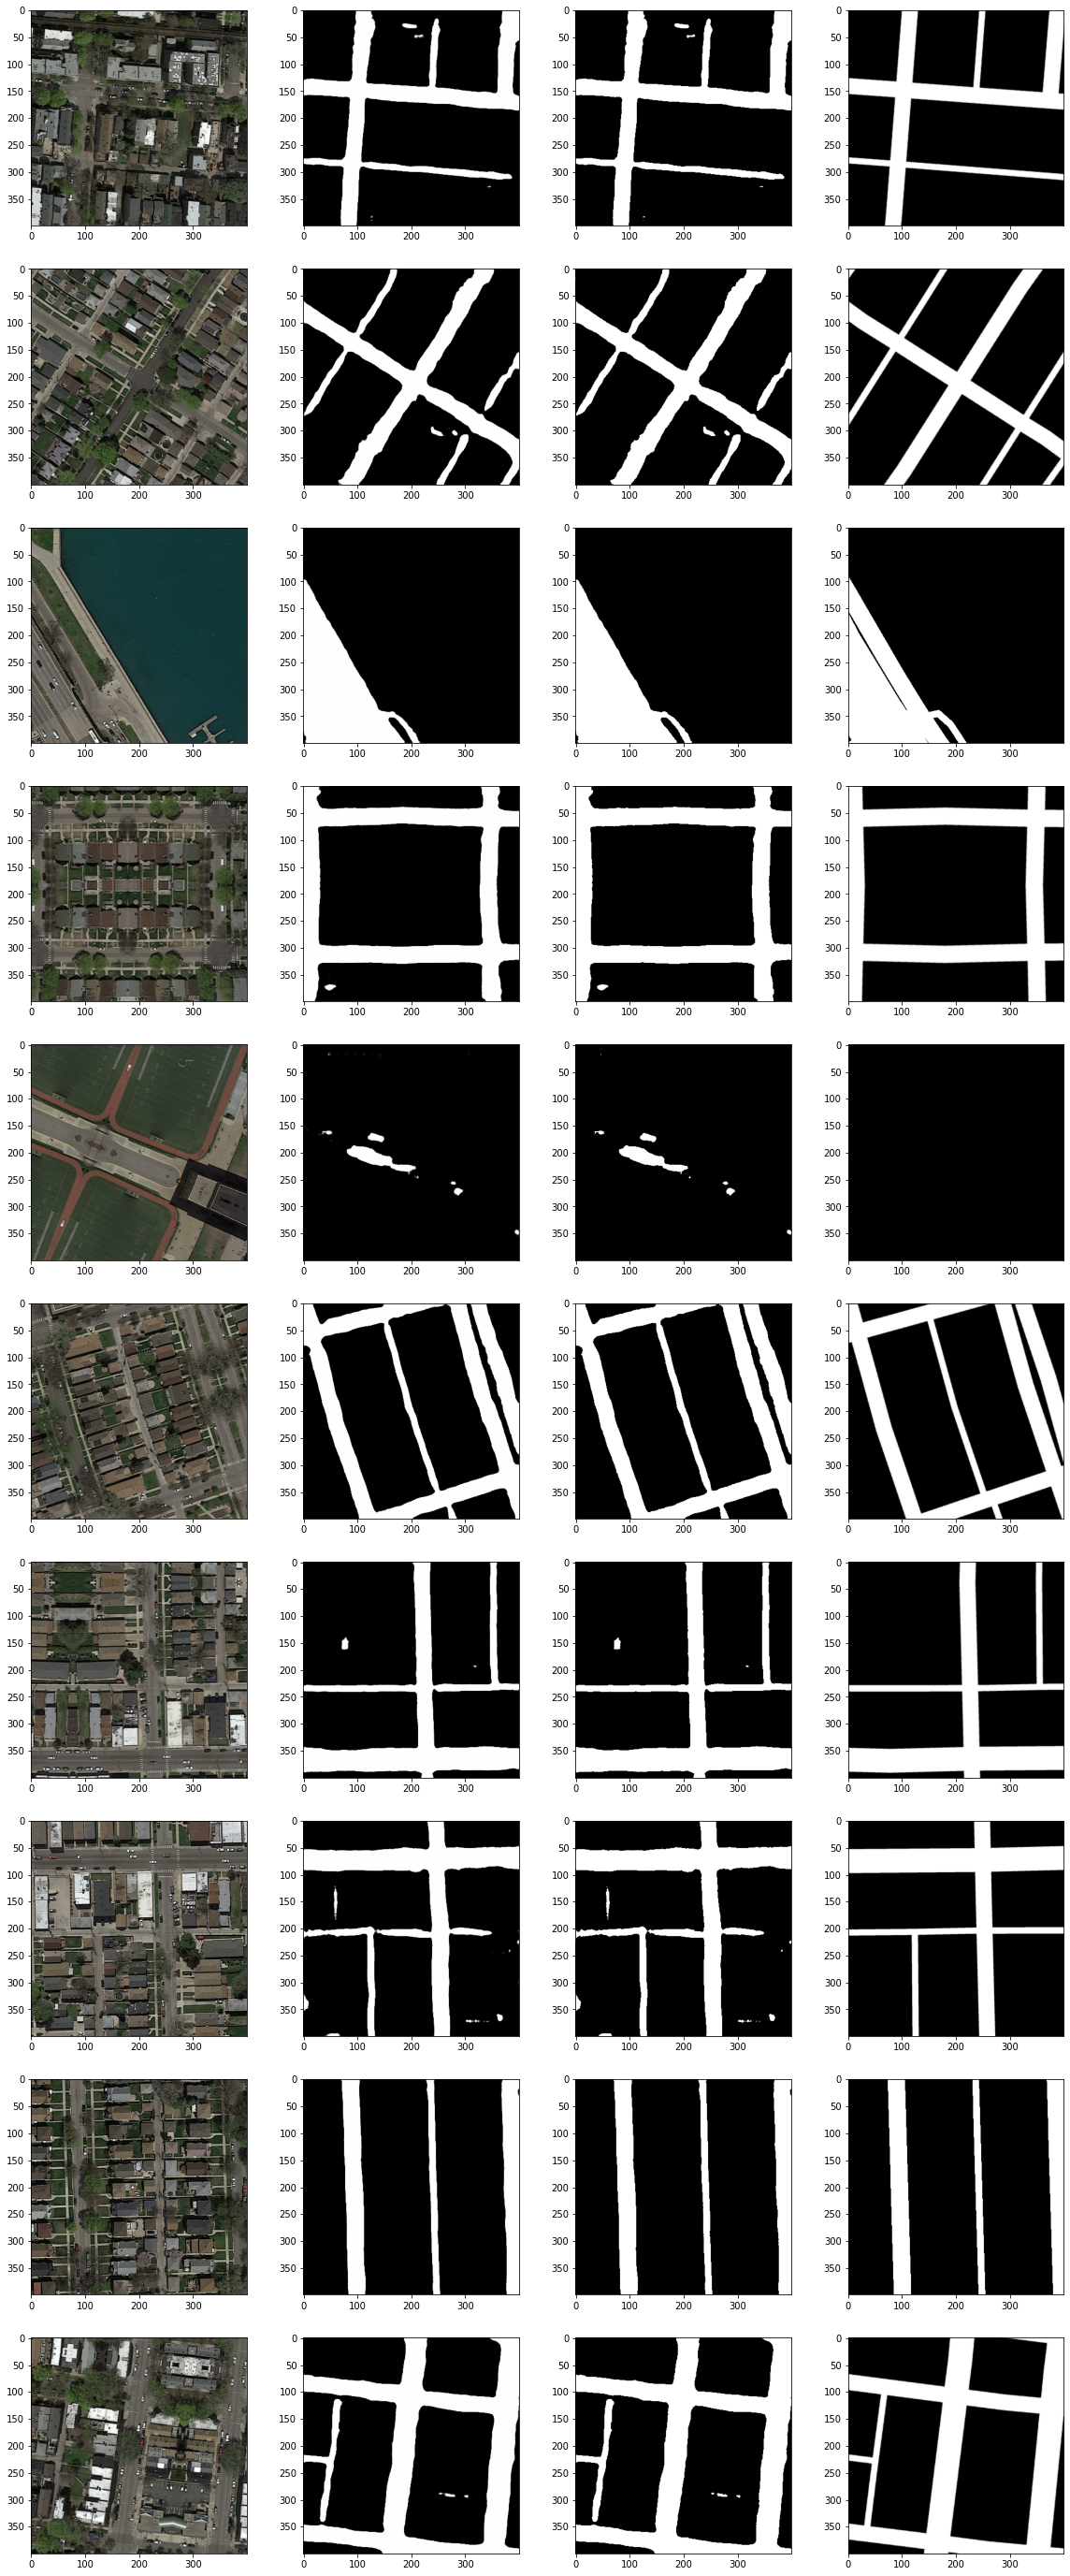

In [17]:
visualize_random_predictions(X_train, y_train, train_predictions, size=10)

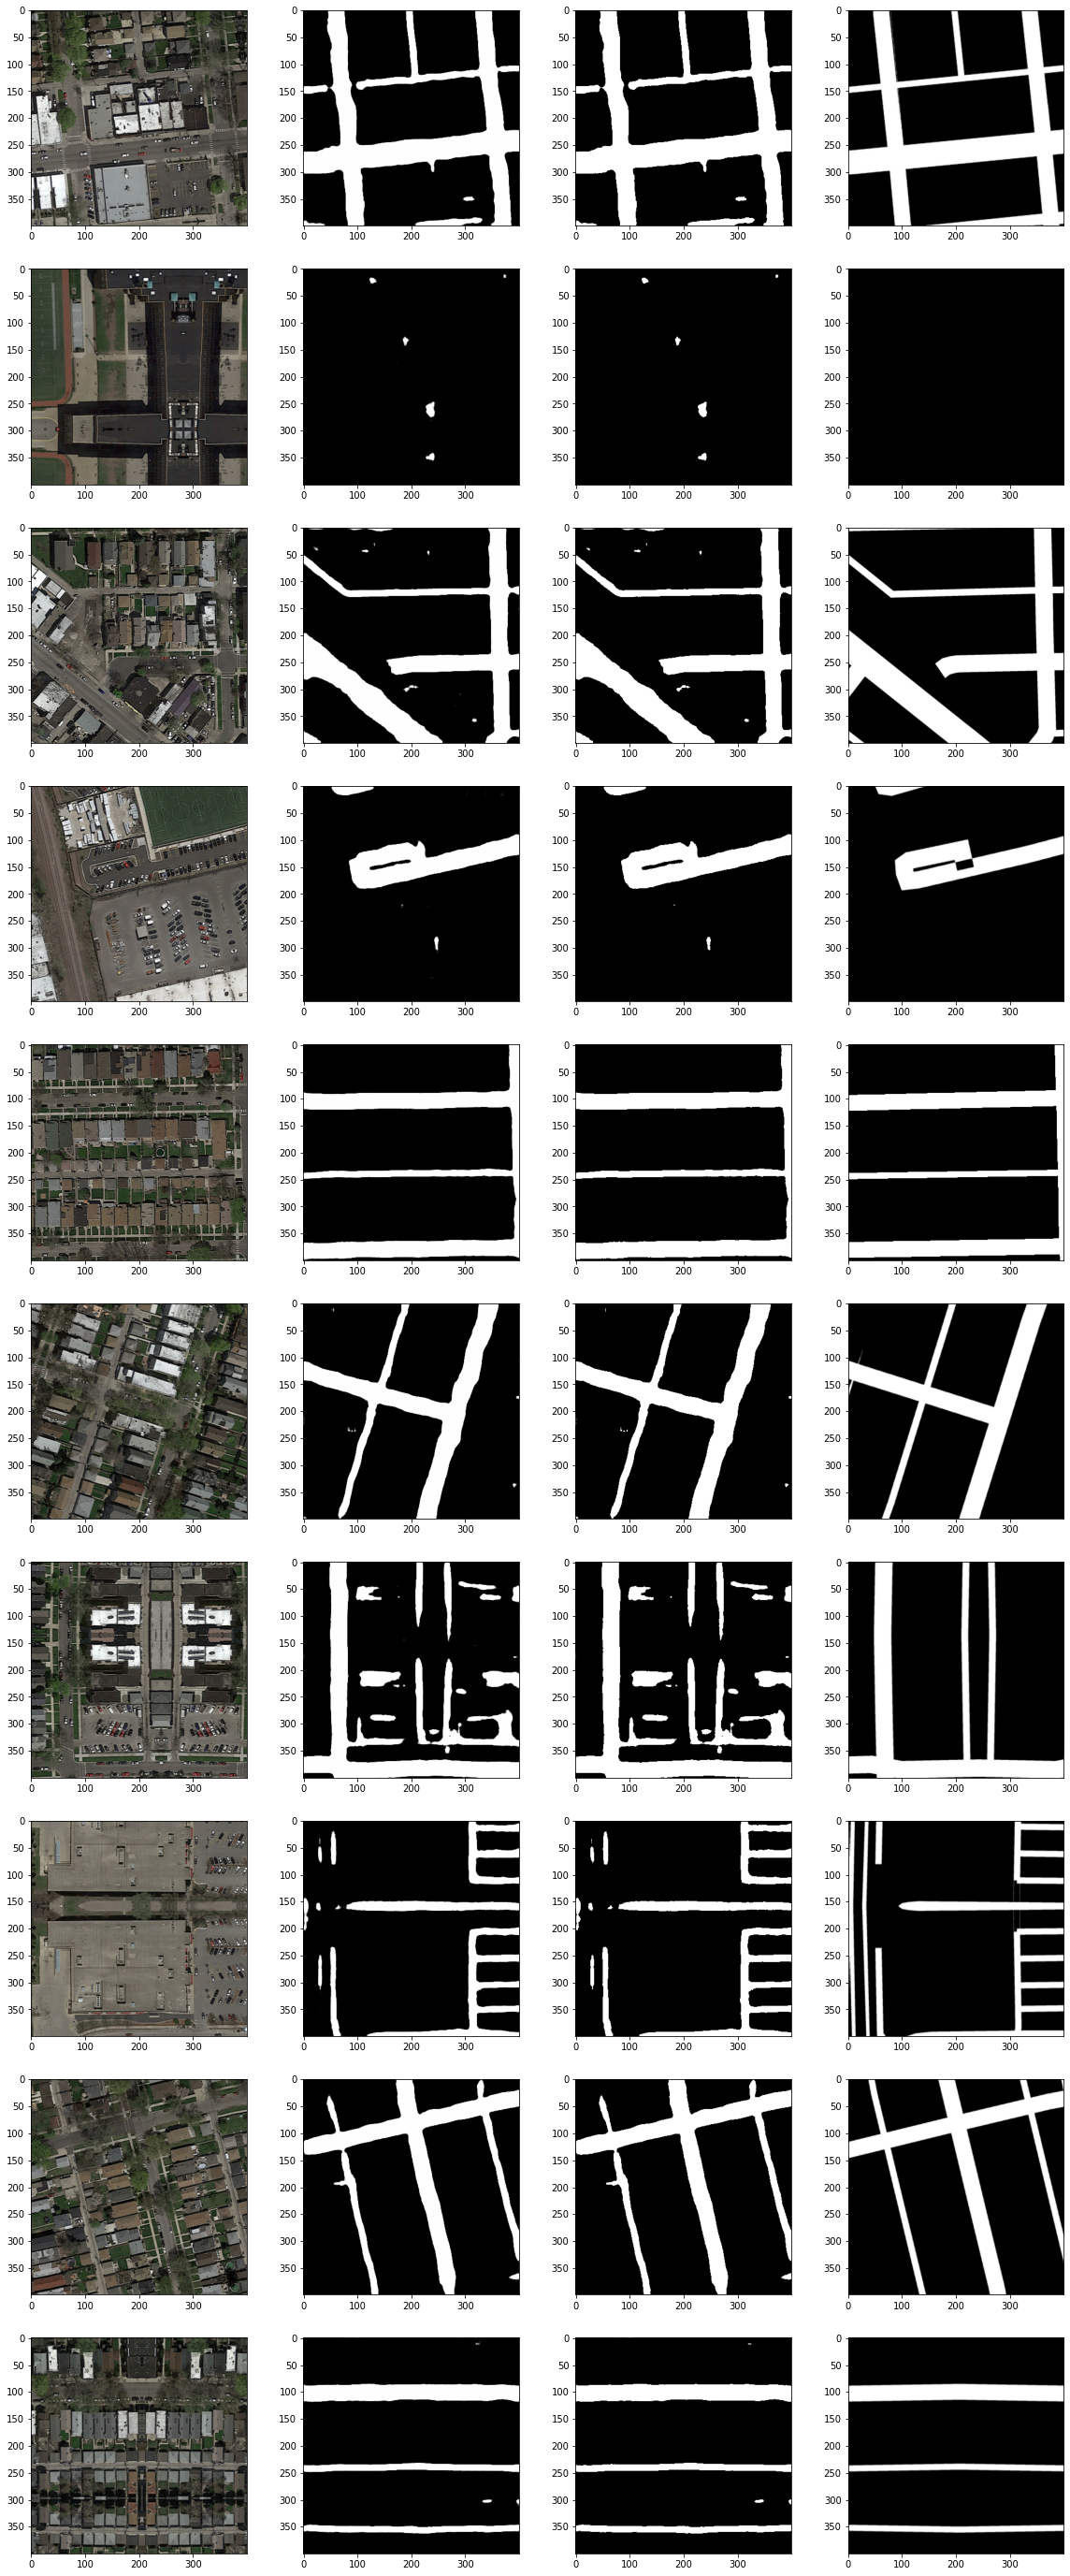

In [18]:
visualize_random_predictions(X_test, y_test, test_predictions, size=10)

In [57]:
compute_entire_images_metrics(y_test, test_predictions)

f1      acc  precision    recall
0  0.852967  0.94517   0.785133  0.933632

In [ ]:
if COLAB:
    from helpers.colab import download_model
    from google.colab import files
    download_model(MODEL_NAME, SAVE_DIR, files)